In [1]:
from gerrychain import Graph

In [2]:
filepath = 'C:/Users/Logan/Desktop\College/IEM4013Project/'
filename= 'AR_county.json'

G = Graph.from_json(filepath + filename)

In [3]:
for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']

In [4]:
dev = 0.01

import math
k = 4
tot_pop = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-dev/2)*tot_pop/k)
U = math.floor((1+dev/2)*tot_pop/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 749117 and U = 756645 and k = 4


In [5]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)    # y[u,v] equals one when edge {u,v} is cut

Set parameter Username
Academic license - for non-commercial use only - expires 2022-06-23


In [6]:
m.setObjective( gp.quicksum( G.edges[u,v]['shared_perim'] * y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [7]:
m.addConstrs( gp.quicksum( x[i,j] for j in range(k)) == 1 for i in G.nodes )

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k) )

m.update()

In [8]:
# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY)

# To solve the MIP faster, fix some district roots:

r[20,0].LB = 1  # fix Oklahoma county as root of district 0
r[37,1].LB = 1 # fix Tulsa county as root of district 1
r[62,2].LB = 1  # fix Comanche county as root of district 2
r[56,3].LB = 1
# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG

import networkx as nx
DG = nx.DiGraph(G)      # directed version of G

f = m.addVars( DG.edges )

In [9]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) ) 

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - y[i,j] ) for i,j in G.edges )

m.update()

In [10]:
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1422 rows, 1176 columns and 5748 nonzeros
Model fingerprint: 0xf1f792f7
Variable types: 384 continuous, 792 integer (792 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+05]
  Objective range  [2e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 389 rows and 338 columns
Presolve time: 0.01s
Presolved: 1033 rows, 838 columns, 4255 nonzeros
Variable types: 382 continuous, 456 integer (456 binary)

Root relaxation: objective 6.025434e+00, 1119 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.02543    0  291          -    6.02543      -     -    0s
     0     0    6.73616    0  302          -    6.73616      -     -  

In [11]:
print("The number of cut edges is",m.objval)

districts = [[i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [[G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k)]

for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 12.00964554654077
District 0 has population 750788 and contains counties ['Faulkner', 'Conway', 'Pulaski', 'Saline', 'Lonoke', 'Perry']

District 1 has population 751754 and contains counties ['Franklin', 'Crawford', 'Benton', 'Madison', 'Sebastian', 'Washington']

District 2 has population 754435 and contains counties ['Jackson', 'Clay', 'Baxter', 'Boone', 'St. Francis', 'Sharp', 'Greene', 'Woodruff', 'White', 'Lee', 'Crittenden', 'Marion', 'Prairie', 'Lawrence', 'Poinsett', 'Stone', 'Independence', 'Fulton', 'Carroll', 'Van Buren', 'Searcy', 'Randolph', 'Izard', 'Craighead', 'Cleburne', 'Monroe', 'Mississippi', 'Newton', 'Cross']

District 3 has population 754547 and contains counties ['Little River', 'Ashley', 'Desha', 'Montgomery', 'Howard', 'Nevada', 'Grant', 'Dallas', 'Cleveland', 'Lafayette', 'Chicot', 'Pope', 'Bradley', 'Drew', 'Pike', 'Union', 'Hempstead', 'Polk', 'Clark', 'Logan', 'Miller', 'Arkansas', 'Johnson', 'Garland', 'Sevier', 'Jefferson', 'L

In [12]:
import geopandas as gpd

filepath = 'C:/Users/Logan/Desktop\College/IEM4013Project/'
filename = 'AR_county.shp'
df = gpd.read_file( filepath + filename)

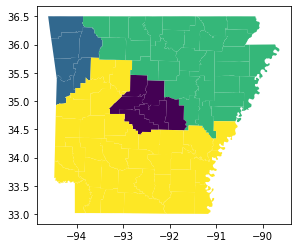

In [13]:
assignment = [ -1 for i in G.nodes ]

labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    i = node_with_this_geoid[geoid]
    assignment[u] = labeling[i]
    
df['assignment'] = assignment
my_fig = df.plot(column='assignment').get_figure()